# Model Predictive Control (MPC)
In this exercise, you will implement a finite-horizon MPC controller for a linear system with state and input constraints.
Complete the `# TODO` sections in the code cells. Use the theory provided below as a guide.
---

## MPC Theory
We consider a linear time-invariant system:
$ x_{k+1} = A x_k + B u_k $

The finite-horizon MPC problem solves:
$
\min_{u_0, ..., u_{N-1}} \sum_{t=0}^{N-1} \left( x_t^\top Q x_t + u_t^\top R u_t \right) + x_N^\top Q_f x_N
$
subject to:
- system dynamics: $ x_{t+1} = A x_t + B u_t $
- input constraints: $ u_{min} \leq u_t \leq u_{max} $
- state constraints: $ x_{min} \leq x_t \leq x_{max} $
- terminal constraint: $ x_N \in \mathcal{X}_f $


##  How to Use `cvxpy` for MPC

This section provides practical guidance for implementing Model Predictive Control (MPC) using the `cvxpy` library, which is a powerful Python framework for convex optimization.

You are solving a **finite-horizon optimal control problem**:

### 1. Problem Formulation

We are given a linear time-invariant system:

$
x_{k+1} = A x_k + B u_k
$

and a cost function:

$
J = \sum_{k=0}^{N-1} \left( x_k^T Q x_k + u_k^T R u_k \right) + x_N^T Q_f x_N
$

subject to:
- system dynamics
- bounds on \( x_k \) (state) and \( u_k \) (control input)

---

### 2. What is `cvxpy`?

`cvxpy` is a Python library for formulating and solving **convex optimization problems**. You define:
- **variables**: e.g. `x = cp.Variable(...)`
- **constraints**: list of conditions like `x >= xmin`
- **objective**: a convex expression to minimize

Then you define a problem using:

```python
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [5]:
# Define system and MPC horizon
# TODO: fill in system matrices
# A = ...
# B = ...

A = np.array([
    [1.0, 1.0],
    [0.0, 1.0]
])

B = np.array([
    [0.0],
    [1.0]
])

# Q = ...
# R = ...
# Qf = ...

Q = np.array([
    [1.0, 0.0],
    [0.0, 1.0]
])       # State cost

R = np.array([[0.1]])  # Control effort cost (small -> more aggressive)

Qf = Q  # Terminal state cost

# N = 10  # horizon
# T = 100  # total simulation time

N = 10
T = 100

In [9]:
# TODO: Implement MPC controller with constraints
# Use cp.quad_form(...) for cost terms
def solve_mpc(x0):

    # reshape the 2D array of x0 into 1D aray
    
    x0 = np.reshape(x0, (2,))

    # optimization variables for x having 2 states
    # and N + 1 time steps

    x = cp.Variable((2, N + 1))

    # optimization variables for x having 1 state
    # and N time steps

    u = cp.Variable((1, N))

    # Define constraints (state and input bounds)
    umin, umax = -1.0, 1.0
    xmin = np.array([-3.0, -2.0])
    xmax = np.array([3.0, 2.0])

    cost = 0

    # initial state is where the position is x0

    constr = [x[:, 0] == x0]

    # for t in range(N):
    #     cost += cp.quad_form(...)
    #     constr += [... dynamics ...]
    #     constr += [... input constraints ...]
    #     constr += [... state constraints ...]

    # sum functions to sum up the cost function
    # from 0 to N - 1

    for t in range(N):

        # cost function x.T @ Q @ x + u.T @ R @ u

        cost += cp.quad_form(x[:, t], Q) + cp.quad_form(u[:, t], R)

        # constr += [... dynamics ...]
        # add system dynamics for each t + 1

        constr += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t]]

        # input constraints

        constr += [umin <= u[:, t]]
        constr += [u[:, t] <= umax]

        # state constraints

        constr += [xmin <= x[:, t]]
        constr += [x[:, t] <= xmax]

    # cost += cp.quad_form(... terminal cost ...)

    cost += cp.quad_form(x[:, t], Q)

    # constr += [... optional terminal constraint ...]

    prob = cp.Problem(cp.Minimize(cost), constr)
    prob.solve(solver=cp.OSQP)
    return u[:, 0].value if u[:, 0].value is not None else np.zeros((1,))

In [10]:
x = np.array([[2.0], [-1.0]])  # shape (2,1)
x_hist = [x.copy()]
u_hist = []

for _ in range(T):
    u = solve_mpc(x)
    u = np.reshape(u, (1, 1))  # ensure u is column vector
    x = A @ x + B @ u
    x_hist.append(x.copy())
    u_hist.append(u.item())

x_hist = np.hstack(x_hist)
u_hist = np.array(u_hist)

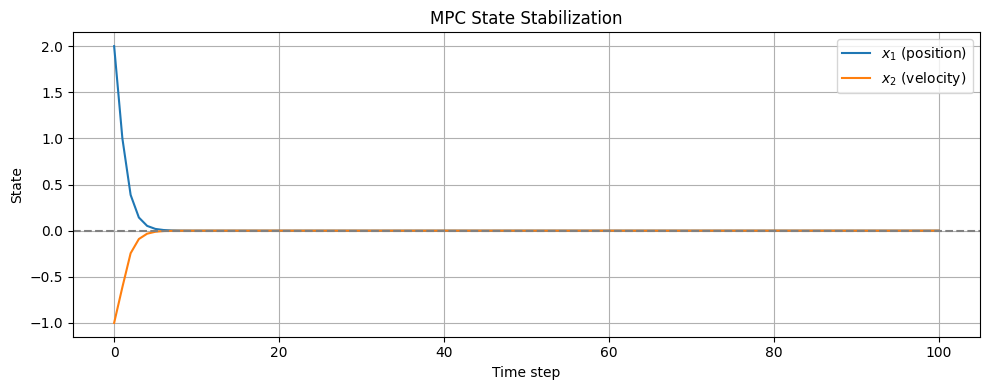

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(x_hist[0, :], label='$x_1$ (position)')
plt.plot(x_hist[1, :], label='$x_2$ (velocity)')
plt.axhline(0, color='gray', linestyle='--')
plt.title('MPC State Stabilization')
plt.xlabel('Time step')
plt.ylabel('State')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

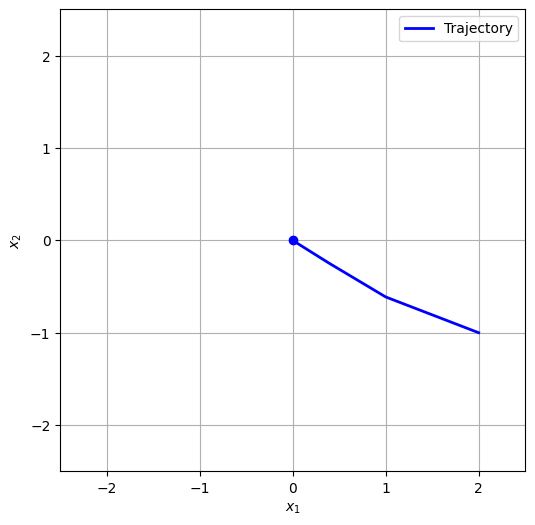

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(True)
line, = ax.plot([], [], 'b-', lw=2, label='Trajectory')
point, = ax.plot([], [], 'bo')
ax.legend()

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def update(frame):
    if frame < 2:
        line.set_data([], [])
        point.set_data([], [])
    else:
        line.set_data(list(x_hist[0, :frame]), list(x_hist[1, :frame]))
        point.set_data([x_hist[0, frame]], [x_hist[1, frame]])
    return line, point

ani = FuncAnimation(fig, update, frames=T, init_func=init, blit=True)
HTML(ani.to_html5_video())